# Expected Loss of Claims - Descartes Underwriting Test

## Doha Kaddaf - Data Science for Business X-HEC 2019-2021

### Dependencies

In [55]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import randint as sp_randint

### Fetch the data

In [2]:
current_path = os.getcwd()
data_path = current_path + '\\data\\'
data_mean_auto = pd.read_csv(data_path+'MEAN_AUTO.csv')
data_shell_auto = pd.read_csv(data_path+'SHELL_AUTO.csv')
data_train_auto = pd.read_csv(data_path+'train_auto.csv')
data_test_auto = pd.read_csv(data_path+'test_auto.csv')

In [3]:
data_train_auto.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
data_train_auto.shape

(8161, 26)

In [5]:
data_test_auto.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


TARGET_AMT needs to be droped because it is a variable to predict.

In [6]:
data_train_auto.drop(['TARGET_AMT'], axis=1, inplace=True)
data_test_auto.drop(['TARGET_AMT'], axis=1, inplace=True)

In [7]:
data_test_auto.shape

(2141, 25)

### Data Cleaning

In [8]:
#Remove index duplicate
data_train_auto.drop(['INDEX'], axis=1, inplace=True)
data_test_auto.set_index('INDEX', inplace=True)

In [9]:
#Get info about the type of data
data_train_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_FR

In [10]:
#Fetch the number of missing values per column in a dictionary
list_col_names = list(data_train_auto.columns)
missing_per_col = dict()
for col_name in list_col_names:
    missing_per_col[col_name] = np.sum(data_train_auto[col_name].isna())

In [11]:
missing_per_col

{'TARGET_FLAG': 0,
 'KIDSDRIV': 0,
 'AGE': 6,
 'HOMEKIDS': 0,
 'YOJ': 454,
 'INCOME': 445,
 'PARENT1': 0,
 'HOME_VAL': 464,
 'MSTATUS': 0,
 'SEX': 0,
 'EDUCATION': 0,
 'JOB': 526,
 'TRAVTIME': 0,
 'CAR_USE': 0,
 'BLUEBOOK': 0,
 'TIF': 0,
 'CAR_TYPE': 0,
 'RED_CAR': 0,
 'OLDCLAIM': 0,
 'CLM_FREQ': 0,
 'REVOKED': 0,
 'MVR_PTS': 0,
 'CAR_AGE': 510,
 'URBANICITY': 0}

So we have 4 float variables and 7 int. The variables containing missing values are:
- AGE: 6 missing values
- YOJ: 454 missing values
- INCOME: 445 missing values
- HOME_VAL: 464 missing values
- JOB: 526 missing values
- CAR_AGE: 510 missing values
I want to take a more closer look on the object variable to know their type.

In [12]:
#Observe the object variables
data_train_auto.select_dtypes(include=['object']).head()

,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
1,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
2,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
3,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,Private,"$15,440",Minivan,yes,$0,No,Highly Urban/ Urban
4,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,Private,"$18,000",z_SUV,no,"$19,217",Yes,Highly Urban/ Urban


- Looking at the data we observe that INCOME, HOME_VAL, BLUEBOOK and OLDCLAIM are numerical data that need to be converted.
- PARENT1, MSTATUS, RED_CAR and REVOKED are boolean/binary with Yes or No (are unique is going to be use to take a look at distinct values).
- SEX is a binary variable M or F.
- CAR_USE is a binary variable: Private or Commercial.
- EDUCATION, JOB, CAR_TYPE and URBANICITY are categorical variables.

In [13]:
#Create a function to modify the numerical variables
def remove_extra_signs_from_numerical(x):
    x = x.replace('$','').replace(',','')
    return x

In [14]:
#Convert objects into numerical variables
list_col_conv_numerical = {'INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM'}
for col_name in list_col_conv_numerical:
    data_train_auto[col_name] = data_train_auto[col_name].astype(str)
    data_train_auto[col_name] = data_train_auto[col_name].apply(remove_extra_signs_from_numerical)
    data_train_auto[col_name] = data_train_auto[col_name].astype(float)
    data_test_auto[col_name] = data_test_auto[col_name].astype(str)
    data_test_auto[col_name] = data_test_auto[col_name].apply(remove_extra_signs_from_numerical)
    data_test_auto[col_name] = data_test_auto[col_name].astype(float)

In [15]:
#Check the format of categorical variables
list_col_cat_names = {'PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED', 'SEX', 'CAR_USE', 'EDUCATION', 'JOB', 'CAR_TYPE', 'URBANICITY'}
val_unique_obj_col = dict()
for col_name in list_col_cat_names:
    val_unique_obj_col[col_name] = list(data_train_auto[col_name].unique())

In [16]:
val_unique_obj_col

{'CAR_USE': ['Private', 'Commercial'],
 'RED_CAR': ['yes', 'no'],
 'MSTATUS': ['z_No', 'Yes'],
 'JOB': ['Professional',
  'z_Blue Collar',
  'Clerical',
  'Doctor',
  'Lawyer',
  'Manager',
  nan,
  'Home Maker',
  'Student'],
 'PARENT1': ['No', 'Yes'],
 'EDUCATION': ['PhD', 'z_High School', '<High School', 'Bachelors', 'Masters'],
 'REVOKED': ['No', 'Yes'],
 'CAR_TYPE': ['Minivan',
  'z_SUV',
  'Sports Car',
  'Van',
  'Panel Truck',
  'Pickup'],
 'SEX': ['M', 'z_F'],
 'URBANICITY': ['Highly Urban/ Urban', 'z_Highly Rural/ Rural']}

In [17]:
#Create a function to modify the categorical variables
def remove_extra_signs_from_categorical(x):
    x = x.replace('z_','').replace('<','')
    return x

In [18]:
#Convert objects into categorical variables
for col_name in list_col_cat_names:
    data_train_auto[col_name] = data_train_auto[col_name].astype(str)
    data_train_auto[col_name] = data_train_auto[col_name].apply(remove_extra_signs_from_categorical)
    data_train_auto[col_name] = data_train_auto[col_name].replace('nan',None)
    data_test_auto[col_name] = data_test_auto[col_name].astype(str)
    data_test_auto[col_name] = data_test_auto[col_name].apply(remove_extra_signs_from_categorical)
    data_test_auto[col_name] = data_test_auto[col_name].replace('nan',None)

In [19]:
#Check if the conversion worked
data_train_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   float64
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   float64
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          8161 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   float64
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   float64
 19  CLM_FR

The data is more coherent now and the number of missing values did not change, so the convertion was successful.

### Data Analysis

In [20]:
data_train_auto.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,67349.0,No,0.0,No,M,...,14230.0,11,Minivan,yes,4461.0,2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,91449.0,No,257252.0,No,M,...,14940.0,1,Minivan,yes,0.0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,...,4010.0,4,SUV,no,38690.0,2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,...,15440.0,7,Minivan,yes,0.0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,114986.0,No,243925.0,Yes,F,...,18000.0,1,SUV,no,19217.0,2,Yes,3,17.0,Highly Urban/ Urban


In [21]:
numerical_col = list(data_train_auto.select_dtypes(include=['int64','float64']).columns)
categorical_col = list(data_train_auto.select_dtypes(include=['object']).columns)

#### Correlation matrix

<AxesSubplot:>

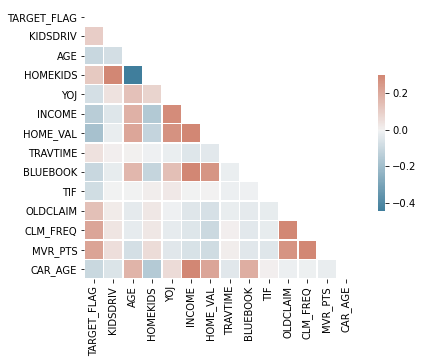

In [22]:
corr = data_train_auto[numerical_col].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

TARGET
Some variables are correlated, a variable selection need to be done.
Variables correlatted posively with TARGET_FLAG: CLM_FREQ and MVR_PTS.
Variables correlatted negatively with TARGET_FLAG: INCOME and HOME_VAL.

### Numerical Variables Distribution Plot

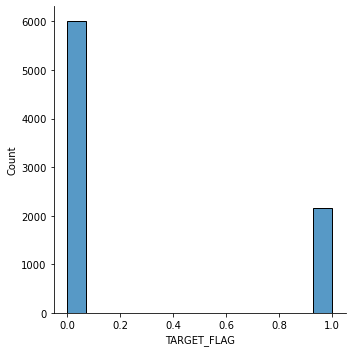

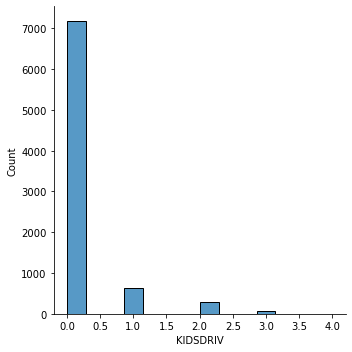

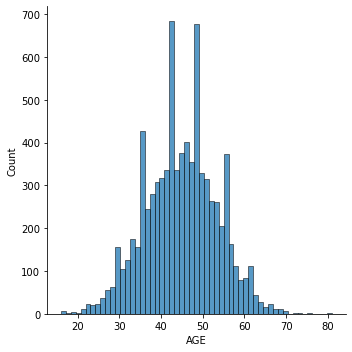

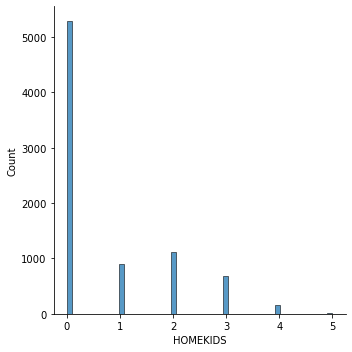

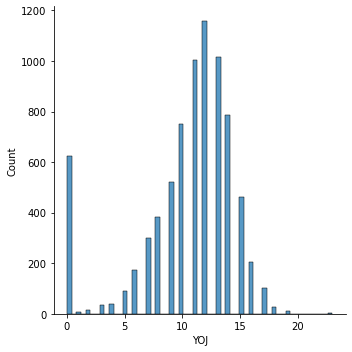

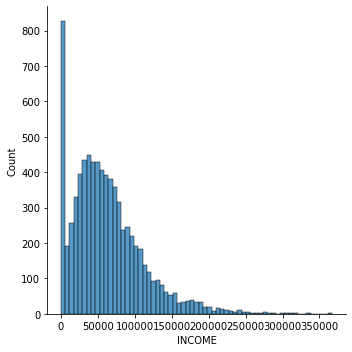

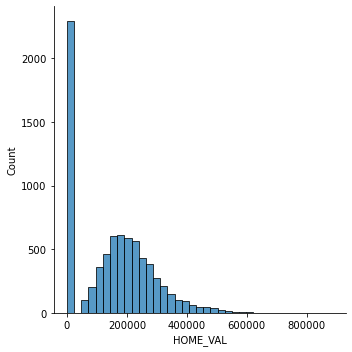

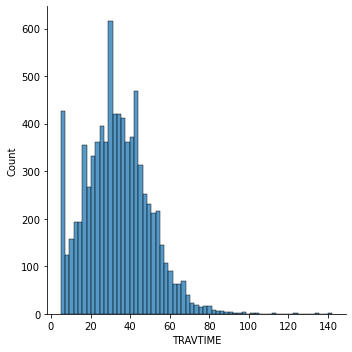

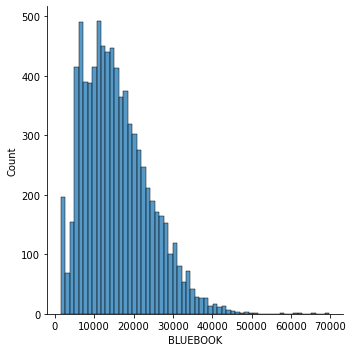

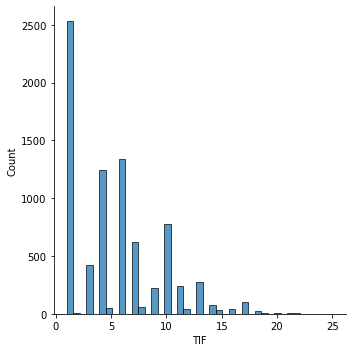

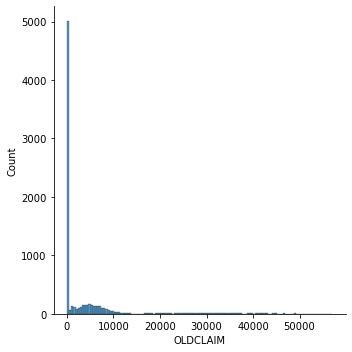

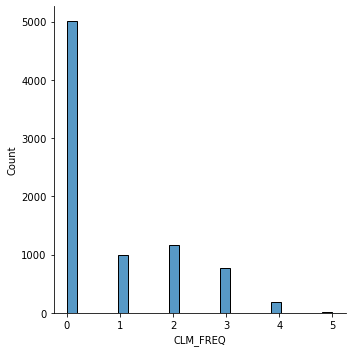

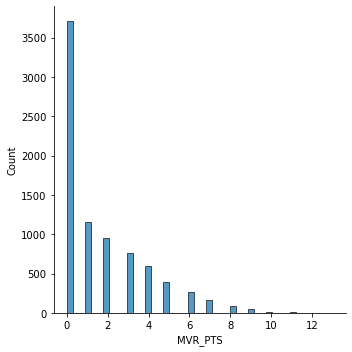

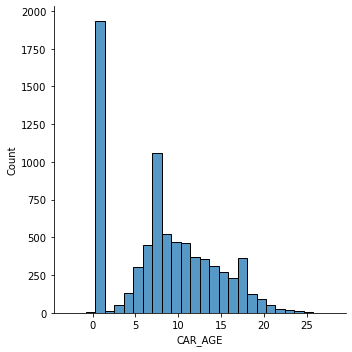

In [23]:
for num_col in numerical_col:
    sns.displot(data=data_train_auto, x=num_col)

- Target Flag is a categorical variable not a numerical one as thought in the begining.
- Target Flag is not that balanced, some undersampling might be needed to improve the estimator efficency.
- When using a classical model such as Linear Regression a logarithmic transformation is needed on highly skewed variables. If Gradient Bosting is used for example there is no need to do so.

### Categorical Variables Count Plot

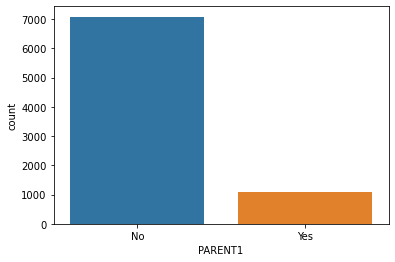

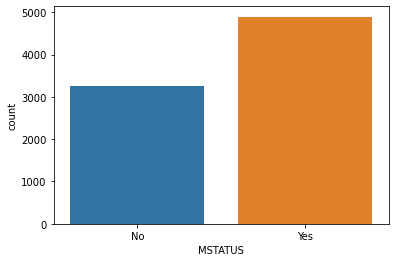

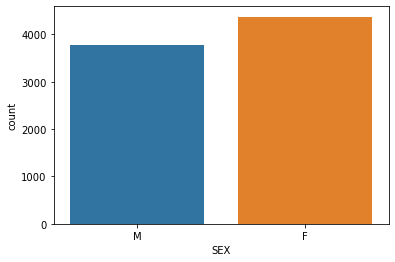

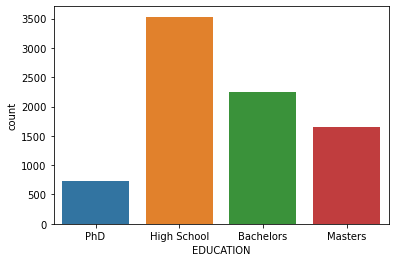

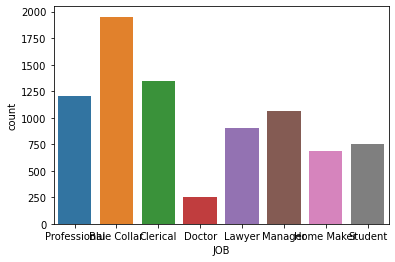

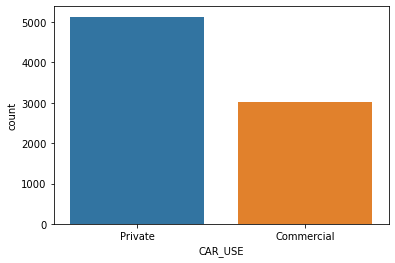

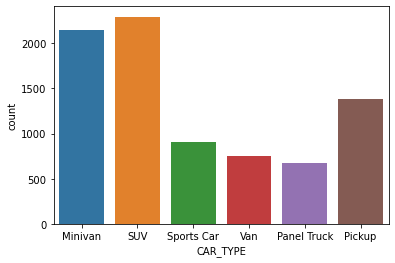

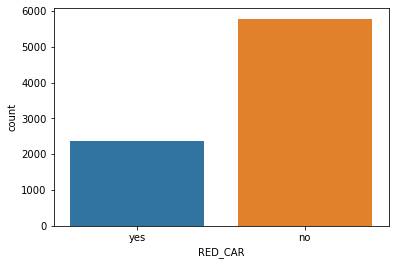

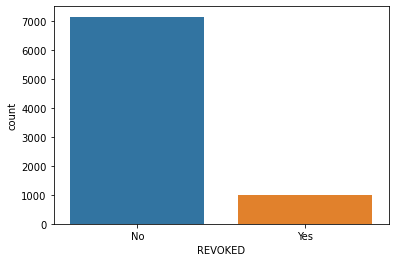

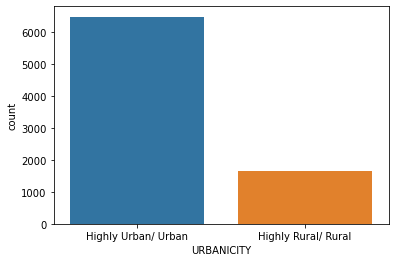

In [24]:
for cat_col in categorical_col:
    plt.figure()
    sns.countplot(data=data_train_auto, x=cat_col)

Some variable are not balanced but it is not that problematic.

### Undersampling No values

In [25]:
#Find indexes of TARGET_FLAG equals 0
indexes = list(data_train_auto[data_train_auto.TARGET_FLAG == 0].index)

In [26]:
#Choose randomly the same amount of TARGET_FLAG equals 1
random.seed(42)
random.shuffle(indexes)
chosen_zeros_indexes = indexes[:np.sum(data_train_auto.TARGET_FLAG == 1)]
chosen_zeros_indexes = np.sort(chosen_zeros_indexes)

In [27]:
#Construct a new undersampled Dataset
data_train_auto_chosen_zeros = data_train_auto.iloc[chosen_zeros_indexes,:]
data_train_auto_undersampled = pd.concat([data_train_auto[data_train_auto.TARGET_FLAG == 1],data_train_auto_chosen_zeros])
data_train_auto_undersampled = data_train_auto_undersampled.sample(frac=1).reset_index(drop=True)

In [28]:
data_train_auto_undersampled.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,48.0,0,9.0,49251.0,No,180173.0,Yes,F,...,11230.0,7,SUV,no,0.0,0,No,0,1.0,Highly Urban/ Urban
1,1,0,47.0,0,8.0,90940.0,No,0.0,No,M,...,16710.0,10,Van,yes,8490.0,3,No,0,10.0,Highly Urban/ Urban
2,1,0,28.0,1,0.0,0.0,Yes,0.0,No,F,...,15370.0,3,Sports Car,no,2747.0,1,No,4,6.0,Highly Urban/ Urban
3,0,0,45.0,0,13.0,278656.0,No,NaN,No,M,...,31310.0,7,Minivan,yes,0.0,0,No,0,16.0,Highly Urban/ Urban
4,1,0,41.0,1,8.0,126468.0,Yes,0.0,No,F,...,32690.0,3,Pickup,no,0.0,0,No,2,18.0,Highly Urban/ Urban


<AxesSubplot:xlabel='TARGET_FLAG', ylabel='count'>

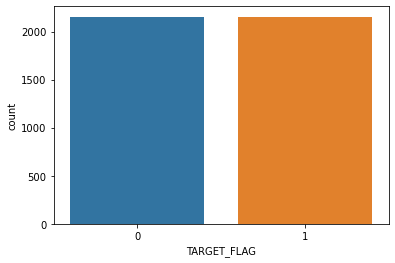

In [29]:
sns.countplot(data=data_train_auto_undersampled, x='TARGET_FLAG')

### Preprocessing Pipeline

In [30]:
#Isolate the Target variable TARGET FLAG
X = data_train_auto_undersampled.loc[:, data_train_auto_undersampled.columns != 'TARGET_FLAG']
X_test = data_test_auto.loc[:, data_test_auto.columns != 'TARGET_FLAG']
y = data_train_auto_undersampled.loc[:, 'TARGET_FLAG']
numerical_col.remove('TARGET_FLAG')

In [31]:
#Construct a data preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_col),
        ('cat', categorical_transformer, categorical_col)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf_rand_forest = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

clf_grad_boost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])
#Test on different type of algorithms
scores = dict()
scores['Logistic Regression Score'] = np.mean(cross_val_score(clf_log_reg, X, y, cv=5, scoring='accuracy'))
scores['Random Forest Score'] = np.mean(cross_val_score(clf_rand_forest, X, y, cv=5, scoring='accuracy'))
scores['Gradient Boosting Score'] = np.mean(cross_val_score(clf_grad_boost, X, y, cv=5, scoring='accuracy'))

In [32]:
scores

{'Logistic Regression Score': 0.7220153547243129,
 'Random Forest Score': 0.723640562557432,
 'Gradient Boosting Score': 0.7450083672199003}

Comparable scores are found using three different models. For simplicity reasons we continue working with Gradient Boosting as it gave the best score.

### Variable Selection - Gradient Boosting

In [33]:
#Preprocess the data once and for all before further computations
X_postpro = preprocessor.fit_transform(X)
X_postpro_test = preprocessor.transform(X_test)

In [34]:
#Function that get that columns name found online. For knowledge purposes only.
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [81]:
#Add the column names to the processed columns
df_X_postpro = pd.DataFrame(X_postpro, columns=get_feature_names(preprocessor))
df_X_postpro_test = pd.DataFrame(X_postpro_test, columns=get_feature_names(preprocessor))
df_X_postpro_test['INDEX'] = X_test.index
df_X_postpro_test.set_index('INDEX', inplace=True)

C:\Users\dohak\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
C:\Users\dohak\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [83]:
df_X_postpro.head()

,num__KIDSDRIV,num__AGE,num__HOMEKIDS,num__YOJ,num__INCOME,num__HOME_VAL,num__TRAVTIME,num__BLUEBOOK,num__TIF,num__OLDCLAIM,...,onehot__x6_Pickup,onehot__x6_SUV,onehot__x6_Sports Car,onehot__x6_Van,onehot__x7_no,onehot__x7_yes,onehot__x8_No,onehot__x8_Yes,onehot__x9_Highly Rural/ Rural,onehot__x9_Highly Urban/ Urban
0,-0.36566,0.426135,-0.697162,-0.352634,-0.188267,0.328662,-1.579639,-0.476527,0.439906,-0.506305,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.36566,0.313486,-0.697162,-0.596560,0.739371,-1.139090,1.012751,0.186926,1.169393,0.419902,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-0.36566,-1.826844,0.169210,-2.547969,-1.284169,-1.139090,-0.441517,0.024695,-0.532744,-0.206624,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.36566,0.088188,-0.697162,0.623071,4.916309,0.051368,-0.125371,1.954522,0.439906,-0.506305,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,-0.36566,-0.362407,0.169210,-0.596560,1.529917,-1.139090,0.001087,2.121596,-0.532744,-0.506305,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [84]:
df_X_postpro_test.head()

,num__KIDSDRIV,num__AGE,num__HOMEKIDS,num__YOJ,num__INCOME,num__HOME_VAL,num__TRAVTIME,num__BLUEBOOK,num__TIF,num__OLDCLAIM,...,onehot__x6_Pickup,onehot__x6_SUV,onehot__x6_Sports Car,onehot__x6_Van,onehot__x7_no,onehot__x7_yes,onehot__x8_No,onehot__x8_Yes,onehot__x9_Highly Rural/ Rural,onehot__x9_Highly Urban/ Urban
INDEX,,,,,,,,,,,,,,,,,,,,,
3,-0.365660,0.426135,-0.697162,0.135219,-0.107494,-1.13909,-0.504746,0.823745,-1.019069,-0.506305,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
9,1.446231,-0.475056,0.169210,0.135219,-0.153466,-1.13909,-0.820891,0.455698,0.196744,-0.146841,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
10,-0.365660,-0.024460,1.035582,0.379145,-0.316546,-1.13909,-0.251830,-1.121821,1.169393,-0.506305,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
18,-0.365660,-1.038301,1.035582,0.135219,-0.812351,-1.13909,2.530248,-0.718664,0.196744,-0.506305,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
21,-0.365660,1.665274,-0.697162,0.379145,0.661936,-1.13909,0.696606,0.030748,-1.019069,4.387319,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [38]:
#Feature Selection using RFE from sklearn
estimator = GradientBoostingClassifier()
selector = RFE(estimator, step=1)
selector = selector.fit(df_X_postpro, y)

In [39]:
selector.support_

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True,  True,  True, False, False,
       False, False, False, False, False,  True,  True,  True,  True])

In [40]:
selector.ranking_

array([ 1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  5,  1,  1,  9,  1,  1,  3,
       14, 20, 11,  1, 22, 24,  4, 13,  6, 15, 19,  1, 18,  8,  1,  1,  1,
       21, 12, 10,  7, 16, 17, 23,  1,  1,  1,  1])

In [85]:
#Construct new datasets with selected features
df_X_postpro_selec = df_X_postpro.loc[:,list(selector.support_)]
df_X_postpro_test_selec = df_X_postpro_test.loc[:,list(selector.support_)]

In [42]:
#Create a dictionary combining each feature and its ranking
post_pro_col_list = list(df_X_postpro)
ranking_col = dict()
for i, rank in enumerate(list(selector.ranking_)):
    ranking_col[post_pro_col_list[i]] = rank

In [43]:
ranking_col

{'num__KIDSDRIV': 1,
 'num__AGE': 1,
 'num__HOMEKIDS': 1,
 'num__YOJ': 2,
 'num__INCOME': 1,
 'num__HOME_VAL': 1,
 'num__TRAVTIME': 1,
 'num__BLUEBOOK': 1,
 'num__TIF': 1,
 'num__OLDCLAIM': 1,
 'num__CLM_FREQ': 5,
 'num__MVR_PTS': 1,
 'num__CAR_AGE': 1,
 'onehot__x0_No': 9,
 'onehot__x0_Yes': 1,
 'onehot__x1_No': 1,
 'onehot__x1_Yes': 3,
 'onehot__x2_F': 14,
 'onehot__x2_M': 20,
 'onehot__x3_Bachelors': 11,
 'onehot__x3_High School': 1,
 'onehot__x3_Masters': 22,
 'onehot__x3_PhD': 24,
 'onehot__x4_Blue Collar': 4,
 'onehot__x4_Clerical': 13,
 'onehot__x4_Doctor': 6,
 'onehot__x4_Home Maker': 15,
 'onehot__x4_Lawyer': 19,
 'onehot__x4_Manager': 1,
 'onehot__x4_Professional': 18,
 'onehot__x4_Student': 8,
 'onehot__x5_Commercial': 1,
 'onehot__x5_Private': 1,
 'onehot__x6_Minivan': 1,
 'onehot__x6_Panel Truck': 21,
 'onehot__x6_Pickup': 12,
 'onehot__x6_SUV': 10,
 'onehot__x6_Sports Car': 7,
 'onehot__x6_Van': 16,
 'onehot__x7_no': 17,
 'onehot__x7_yes': 23,
 'onehot__x8_No': 1,
 'oneho

In [44]:
#View important variables
important_var = {k:v for (k,v) in ranking_col.items() if v <4}

The most important variables:

In [45]:
list(important_var.keys())

['num__KIDSDRIV',
 'num__AGE',
 'num__HOMEKIDS',
 'num__YOJ',
 'num__INCOME',
 'num__HOME_VAL',
 'num__TRAVTIME',
 'num__BLUEBOOK',
 'num__TIF',
 'num__OLDCLAIM',
 'num__MVR_PTS',
 'num__CAR_AGE',
 'onehot__x0_Yes',
 'onehot__x1_No',
 'onehot__x1_Yes',
 'onehot__x3_High School',
 'onehot__x4_Manager',
 'onehot__x5_Commercial',
 'onehot__x5_Private',
 'onehot__x6_Minivan',
 'onehot__x8_No',
 'onehot__x8_Yes',
 'onehot__x9_Highly Rural/ Rural',
 'onehot__x9_Highly Urban/ Urban']

### Hyperparameter Optimization - Gradient Boosting XGBoost

In [46]:
#Define an estimator with a coherent n_estimators*learning_rate
clfe = xgb.XGBClassifier(n_estimators=1000,
                       objective='binary:logistic',
                       learning_rate=0.005,
                      )
 
#List of parameters and their values to choose randomly from
param_dist = {
                    'max_depth':[2, 4, 6, 8, 10, 12],  
                    'min_child_weight':[4, 5, 6, 7, 8],

                    'subsample':np.arange(0.70, 1.00, 0.01),
                    'colsample_bytree': np.arange(0.30, 1, 0.1), 
                    'colsample_bylevel': np.arange(0.30, 1, 0.1),
                    'colsample_bynode': np.arange(0.30, 1, 0.1),
                    'reg_alpha':[.001, .005, .0005],
                    'reg_lambda':[.001, .005, .0005],
                    }



# run randomized search
n_iter_search = 100

random_search = RandomizedSearchCV(clfe, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='accuracy',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(df_X_postpro_selec, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.4min finished
C:\Users\dohak\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(learning_rate=0.005,
                                           n_estimators=1000),
                   iid=False, n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bynode': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'min_child_weight': [4, 5, 6, 7, 8],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 

In [47]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, 5)   

Model with rank: 1
Mean validation score: 0.747 (std: 0.013)
Parameters: {'subsample': 0.9800000000000002, 'reg_lambda': 0.0005, 'reg_alpha': 0.005, 'min_child_weight': 4, 'max_depth': 12, 'colsample_bytree': 0.7000000000000002, 'colsample_bynode': 0.3, 'colsample_bylevel': 0.6000000000000001}

Model with rank: 2
Mean validation score: 0.746 (std: 0.015)
Parameters: {'subsample': 0.73, 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 'min_child_weight': 4, 'max_depth': 10, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.4}

Model with rank: 3
Mean validation score: 0.745 (std: 0.012)
Parameters: {'subsample': 0.9900000000000002, 'reg_lambda': 0.0005, 'reg_alpha': 0.001, 'min_child_weight': 5, 'max_depth': 12, 'colsample_bytree': 0.7000000000000002, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.4}

Model with rank: 4
Mean validation score: 0.745 (std: 0.012)
Parameters: {'subsample': 0.8600000000000001, 'reg_lambda': 0.005, 'reg_alpha': 0.001, 'min_chi

In [51]:
#Lauching the classifier with the optimal parameters and doing a cross-validation score
params =  {'subsample': 0.9800000000000002,
           'reg_lambda': 0.0005,
           'reg_alpha': 0.005,
           'min_child_weight': 4,
           'max_depth': 12,
           'colsample_bytree': 0.7000000000000002,
           'colsample_bynode': 0.3,
           'colsample_bylevel': 0.6000000000000001}

final_model = xgb.XGBClassifier(**params)

scores = cross_val_score(final_model, df_X_postpro_selec, y, cv=5, scoring='accuracy')

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.02)


The accuracy did not improve after variablre selection and hyper-parameter optimization.

### Final Model - Test Prediction

In [86]:
#Applying the model on all the train data
final_model_for_test = xgb.XGBClassifier(**params)
final_model_for_test.fit(df_X_postpro_selec, y)

#Predicting values for the test data
y_test = final_model_for_test.predict(df_X_postpro_test_selec)

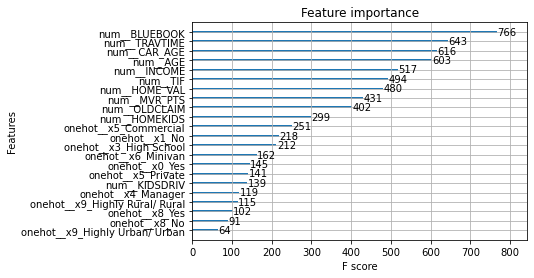

In [87]:
#View features importance
plot_importance(final_model_for_test)
plt.show()

In [99]:
#Save the predicted values for the test set in a csv.
df_test_results = pd.DataFrame(y_test, index=df_X_postpro_test_selec.index, columns=['TARGET_FLAG'])
df_test_results.to_csv('results_y_test.csv', index=True, sep=';')